## Decision Trees for Classification and Regression
Learn about decision trees, how they work and how they can be used for classification and regression tasks.

Introduction
Decision trees are a common type of machine learning model used for binary classification tasks. The natural structure of a binary tree lends itself well to predicting a “yes” or “no” target. It is traversed sequentially here by evaluating the truth of each logical statement until the final prediction outcome is reached. Some examples of classification tasks that can use decision trees are: predicting whether a student will pass or fail an exam, whether an email is spam or not, if transaction is fraudulent or legitimate, etc

Decision trees can also be used for regression tasks! Predicting the grade of a student on an exam, the number of spam emails per day, the amount of fraudulent transactions on a platform, etc. are all possible using decision trees. The algorithm works pretty much the same way, with modifications only to the splitting criteria and how the final output it computed. 
In this project, we will explore both a binary classification and regression model using decision trees with the Indian Graduate Admissions dataset.

#### Dataset
The data contains features commonly used in determining admission to masters’ degree programs, such as GRE, GPA, and letters of recommendation. The complete list of features is summarized below:

- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 )


In [35]:

import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
df = pd.read_csv("Admission_Predict.csv")
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()



Decision Trees for Classification: A Recap
As a first step, we will create a binary class (1=admission likely , 0=admission unlikely) from the chance of admit – greater than 80% we will consider as likely. The remaining data columns will be used as predictors.


In [23]:
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']>=.8

#### Fitting and Predicting
We will use scikit-learn‘s tree module to create, train, predict, and visualize a decision tree classifier. 
As with other scikit-learn models, only numeric data can be used (categorical variables and nulls must be handled prior to model fitting). In this case, our categorical features have already been transformed and no missing values are present in the data set.


In [24]:
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01,criterion='gini')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print("Classifier score on Test data:", dt.score(x_test, y_test))


Classifier score on Test data: 0.925


Two methods are available to visualize the tree within the tree module:
- tree_plot to graphically represent the decision tree
- export_text to list the rules behind the splits in the decision tree.

|--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



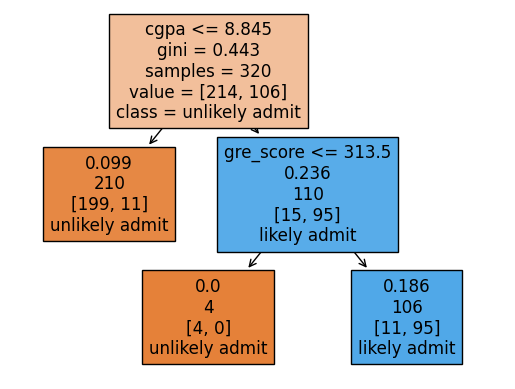

In [25]:
tree.plot_tree(dt, feature_names = list(X.columns),
               max_depth=3, class_names = ['unlikely admit', 'likely admit'],
               label='root', filled=True)
print(tree.export_text(dt, feature_names = X.columns.tolist()))


#### Split Criteria
For a classification task, the default split criteria is Gini impurity – this gives us a measure of how “impure” the groups are. At the root node, the first split is then chosen as the one that maximizes the information gain, i.e. decreases the Gini impurity the most.

Our tree has already been built for us, to verify, we will use the defined functions gini and info_gain.


In [26]:
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)
   
gi = gini(y_train)
print(f'Gini impurity at root: {round(gi,3)}')



Gini impurity at root: 0.443


In [27]:
def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

#Next, we are going to verify how the split on cgpa was determined, i.e. where did the 8.845 value come from. We will use info_gain over ALL values of cgpa to determine the information gain when split on each value. This is stored in a table and sorted, and voila, the top value for the split is cgpa<=8.845! This is also done for every other feature (and for those continuous ones, every value), to find the top split overall.

info_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    info_gain_list.append([i, info_gain(left, right, gi)])

ig_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
ig_table.head(10)



,split_value,info_gain
10,8.84,0.296932
124,8.85,0.291464
139,8.88,0.290704
18,8.90,0.290054
98,8.83,0.287810
110,8.87,0.286050
152,8.94,0.284714
57,8.96,0.284210
96,8.80,0.283371
21,9.00,0.283364


Text(0, 0.5, 'info gain')

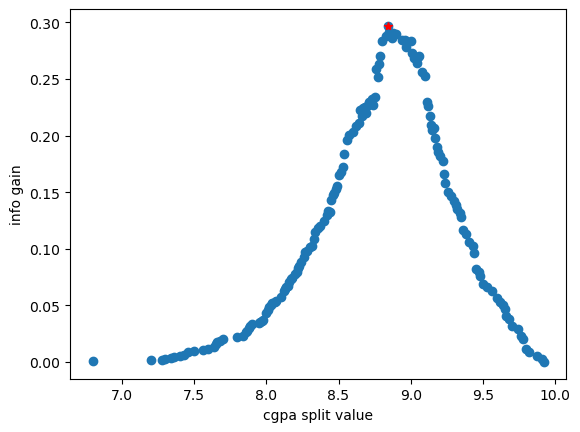

In [28]:
plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0], ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')



After this process is repeated, and there is no further info gain by splitting, the tree is finally built. Last to evaluate, any sample traverses through tree and appropriate splits until it reaches a leaf node, and then assigned the majority class of that leaf (or weighted majority).

### Regression
For the regression problem, we will use the unaltered chance_of_admit target, which is a floating point value between 0 and 1.


Regressor score: 0.5230242793515549


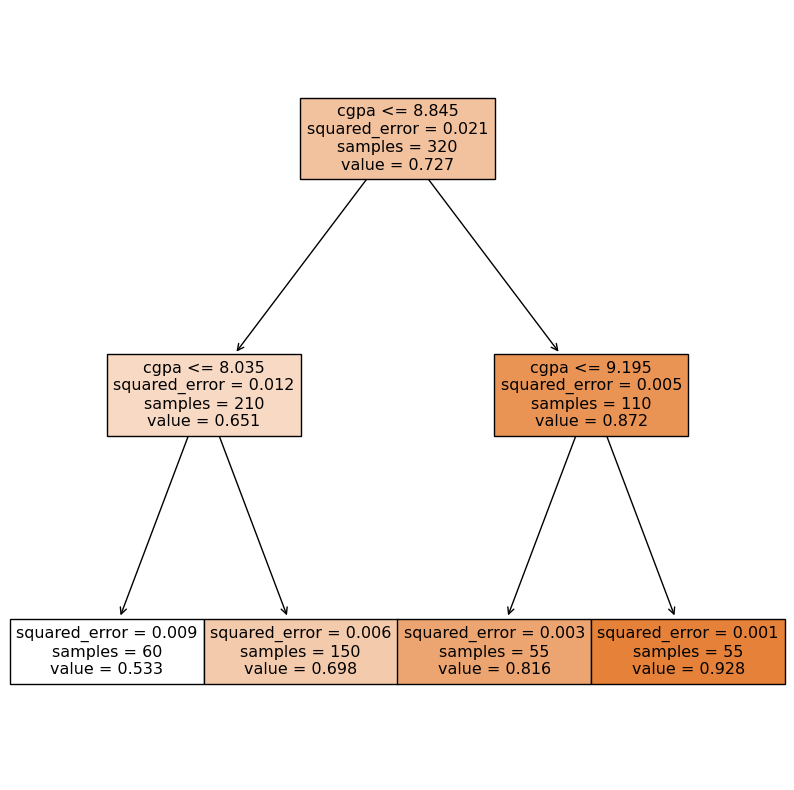

In [33]:
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']

#Fitting and Predicting
#The syntax is identical as the decision tree classifier, except the target, y, must be real-valued and the model used must be DecisionTreeRegressor(). As far as the model hyperparameters go, almost all are the same, except for the split criterion. The split criterion now needs be suitable for a regression task – the default for regression is Mean Squared Error (or MSE). Let’s investigate this:

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeRegressor(max_depth=3, ccp_alpha=0.001)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print("Regressor score:", dt.score(x_test, y_test))

#Similarly, the tree can be visualized using tree.plot_tree – keeping in mind the splitting criteria is mse and the value is the average chance_of_admit of all samples in that leaf.

plt.figure(figsize=(10,10))
tree.plot_tree(dt, feature_names = list(X.columns),  
               max_depth=2, filled=True);



#### Split Criteria
Unlike the classification problem, there are no longer classes to split the tree by. Instead, at each level, the value is the average of all samples that fit the logical criteria.

In terms of evaluating the split, the default method is MSE.
Now to determine the split, for each value of cpga, the information gain, or decrease in MSE after the split, is calculated and then values are sorted.

Further instead of Gini impurity, MSE is used, and the information gain function is modified to mse_gain.


In [36]:
def mse(data):
    """Calculate the MSE of a data set
    """
    return np.mean((data - data.mean())**2)
   
def mse_gain(left, right, current_mse):
    """Information Gain (MSE) associated with creating a node/split data based on MSE.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_mse - w * mse(left) - (1 - w) * mse(right)

m = mse(y_train)
print(f'MSE at root: {round(m,3)}')

mse_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    mse_gain_list.append([i, mse_gain(left, right, m)])

mse_table = pd.DataFrame(mse_gain_list,columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(mse_table.head(10))



MSE at root: 0.021
     split_value  info_gain
10          8.84   0.011065
96          8.80   0.011037
98          8.83   0.011023
124         8.85   0.010985
125         8.73   0.010939
110         8.87   0.010932
139         8.88   0.010895
1           8.70   0.010894
17          8.76   0.010858
140         8.74   0.010850


Text(0, 0.5, 'info gain')

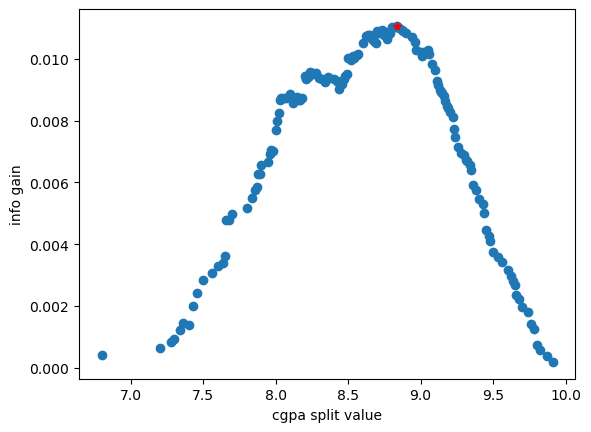

In [37]:
plt.plot(mse_table['split_value'], mse_table['info_gain'],'o')
plt.plot(mse_table['split_value'].iloc[0], mse_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')



Again, the process will continue until there is no increase in information gain by splitting. 
Any sample traverses through the tree until it reaches a leaf node and is then assigned the average value of the samples in leaf. Depending on the depth of the tree, the predicted values can be limited.

In this example, only four unique predicted values are possible, which we can verify. When using a decision tree regressor, unlike linear/logistic regression, not all output values may be possible.


In [39]:
np.unique(dt.predict(x_train))



array([0.53283333, 0.6976    , 0.81618182, 0.92781818])

### Summary
We’ve seen how decision trees can be used for both classification and regression tasks.
